<a href="https://colab.research.google.com/github/Jingut/EX/blob/main/Exp_10(Project_Upgrade_Translator_to_Word_Level).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import shutil
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
print(tf.__version__)

2.9.1


In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

##1. 구두점(Punctuation)을 단어와 분리해주세요.
일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization)이라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요. 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.

예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면

['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로

좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.

!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다.

이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!

분리 후 : he is a Good boy !

##2. 소문자로 바꿔주세요.
기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !

변환 후 : he is a good boy !

##3. 띄어쓰기 단위로 토큰를 수행하세요.
띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

토큰화 전 : 'he is a good boy !'

토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']



In [ ]:
import os
file_path = '/content/drive/MyDrive/seq_te_seq/data/fra-eng/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
158275,Tom volunteered to pay for the damages.,Tom s'est porté volontaire pour payer les domm...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
57345,Is her father a doctor?,Son père est-il médecin ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
129184,I've got to go to the men's room.,Il faut que j'aille aux toilettes.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2246,Just relax.,Détends-toi.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
68331,You're quite attractive.,Tu es tout à fait attirant.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [ ]:
lines_copy = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines_copy.sample(5)

,eng,fra
4191,What a jerk!,Quel naze !
21713,Where did you go?,Où vous êtes-vous rendus ?
14281,I only need one.,Je n'en ai besoin que d'un.
20343,That's our house.,C'est notre résidence.
25925,There's a witness.,Il y a là un témoin.


In [ ]:
lines_copy.shape

(33000, 2)

In [ ]:
lines_copy

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
...,...,...
32995,What did Tom steal?,Qu'est-ce que Tom a volé ?
32996,What did Tom write?,Qu'est-ce que Tom a écrit ?
32997,What did they want?,Que voulaient-ils ?
32998,What did they want?,Que voulaient-elles ?


In [ ]:
lines_copy['eng']

0                        Go.
1                        Go.
2                        Go.
3                        Hi.
4                        Hi.
                ...         
32995    What did Tom steal?
32996    What did Tom write?
32997    What did they want?
32998    What did they want?
32999    What did you drink?
Name: eng, Length: 33000, dtype: object

In [ ]:
lines_copy

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
...,...,...
32995,What did Tom steal?,Qu'est-ce que Tom a volé ?
32996,What did Tom write?,Qu'est-ce que Tom a écrit ?
32997,What did they want?,Que voulaient-ils ?
32998,What did they want?,Que voulaient-elles ?


In [ ]:
# import nltk
# nltk.download('punkt')

# from nltk.tokenize import word_tokenize
# tokenized_word = word_tokenize(str(lines))
# list(tokenized_word) 망한코드

#Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.
글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 가 필요합니다.

예를 들어 번역 문장이 Courez!이었다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['', 'courez', '!']

레이블 시퀀스 : ['courez', '!', ']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!

Step 1을 수행하는 중간에 수행해도 상관없습니다.



In [ ]:
# 시작 토큰과 종료 토큰 추가
sos_token = '<sos>'
eos_token = '<eos>'
lines_copy.fra = lines_copy.fra.apply(lambda x : '<sos> ' + x + ' <eos>')
print('전체 샘플의 수 :',len(lines_copy))
lines_copy.sample(5)

전체 샘플의 수 : 33000


,eng,fra
13754,How old are you?,<sos> Tu as quel âge ? <eos>
4424,Are you lost?,<sos> Êtes-vous perdu ? <eos>
30796,It's our only show.,<sos> C'est notre unique spectacle. <eos>
13477,Give them to me.,<sos> Donnez-les-moi ! <eos>
24350,I went on reading.,<sos> Je poursuivis ma lecture. <eos>


In [ ]:
lines_copy['eng'] = lines_copy['eng'].str.replace(pat =r'([\"?.!,¿])',repl=r' \1', regex=True)
lines_copy['fra'] = lines_copy['fra'].str.replace(pat =r'([\"?.!,¿])',repl=r' \1', regex=True)

lines_copy['eng'] = lines_copy['eng'].str.replace(pat =r'([\"])',repl=r" ", regex=True)
lines_copy['fra'] = lines_copy['fra'].str.replace(pat =r'[\"]+',repl=r" ", regex=True)

lines_copy['eng'] = lines_copy['eng'].str.lower()
lines_copy['fra'] = lines_copy['fra'].str.lower()

lines_copy['eng'] = lines_copy['eng'].str.split()
lines_copy['fra'] = lines_copy['fra'].str.split()

In [ ]:
lines_copy.head()

,eng,fra
0,[go],"[<sos>, va, !, <eos>]"
1,[go],"[<sos>, marche, ., <eos>]"
2,[go],"[<sos>, bouge, !, <eos>]"
3,[hi],"[<sos>, salut, !, <eos>]"
4,[hi],"[<sos>, salut, ., <eos>]"


In [ ]:
lines_copy.fra[:3]

0        [<sos>, va, !, <eos>]
1    [<sos>, marche, ., <eos>]
2     [<sos>, bouge, !, <eos>]
Name: fra, dtype: object

#Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.
딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스 토크나이저의 사용법은

아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다.

[위키독스](https://wikidocs.net/31766)

위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.



In [ ]:
eng_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines_copy.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines_copy.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[23], [23], [23]]

In [ ]:
fra_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines_copy.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines_copy.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 710, 7, 2]]

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4805
프랑스어 단어장의 크기 : 9989


In [ ]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 15


In [ ]:
print('전체 샘플의 수 :',len(lines_copy))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4805
프랑스어 단어장의 크기 : 9989
영어 시퀀스의 최대 길이 6
프랑스어 시퀀스의 최대 길이 15


In [ ]:
fra_tokenizer.word_index['<sos>']

1

In [ ]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [ ]:
# encoder_input = to_categorical(encoder_input)# to categorical 필요없
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 6)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [ ]:
n_of_val = 3000 # 검증데이터 분리

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 6)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 15)


#Step 4. 임베딩 층(Embedding layer) 사용하기
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.

임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의

1. 케라스 임베딩 층(Keras Embedding layer) 를 참고하세요.


[위키독스](https://wikidocs.net/33793)

실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다.

이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.

from tensorflow.keras.layers import Input, mbedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))

enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)

encoder_lstm = LSTM(hidden state의 크기, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,

디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!

In [ ]:
embedding_dim = 64
hidden_units = 64

#Step 5. 모델 구현하기
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요!

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [ ]:
# 인코더
encoder_inputs = Input(shape=(None, ))
# 임베딩 층
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) 
# 패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb) 
# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units, return_state=True)
# 은닉 상태와 셀 상태를 리턴
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) 
# 인코더의 은닉 상태와 셀 상태를 저장
encoder_states = [state_h, state_c] 

In [ ]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, ))
# 임베딩 층
dec_emb_layer = Embedding(fra_vocab_size, hidden_units)
# 패딩 0은 연산에서 제외
dec_emb = dec_emb_layer(decoder_inputs)

dec_masking = Masking(mask_value=0.0)(dec_emb)
# hidden size가 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(hidden_units, return_sequences = True, return_state=True) # 유닛개수변경

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)
# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측

In [ ]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()
# sparse_categorical_crossentropy를 써야만 하는 이유는 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     307520      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     639296      ['input_2[0][0]']                
                                                                                              

In [ ]:
his = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)


Epoch 1/50
235/235 [==============================] - 21s 42ms/step - loss: 2.8344 - acc: 0.6538 - val_loss: 2.0466 - val_acc: 0.7138
Epoch 2/50
235/235 [==============================] - 7s 30ms/step - loss: 1.6082 - acc: 0.7585 - val_loss: 1.8526 - val_acc: 0.7281
Epoch 3/50
235/235 [==============================] - 7s 31ms/step - loss: 1.4726 - acc: 0.7704 - val_loss: 1.7792 - val_acc: 0.7406
Epoch 4/50
235/235 [==============================] - 7s 31ms/step - loss: 1.3669 - acc: 0.7865 - val_loss: 1.6552 - val_acc: 0.7592
Epoch 5/50
235/235 [==============================] - 7s 31ms/step - loss: 1.2732 - acc: 0.8016 - val_loss: 1.5800 - val_acc: 0.7679
Epoch 6/50
235/235 [==============================] - 7s 31ms/step - loss: 1.2064 - acc: 0.8119 - val_loss: 1.5385 - val_acc: 0.7723
Epoch 7/50
235/235 [==============================] - 7s 31ms/step - loss: 1.1542 - acc: 0.8192 - val_loss: 1.4994 - val_acc: 0.7799
Epoch 8/50
235/235 [==============================] - 7s 31ms/step -

In [ ]:
import matplotlib.pyplot as plt
his_dict = his.history
print(his_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


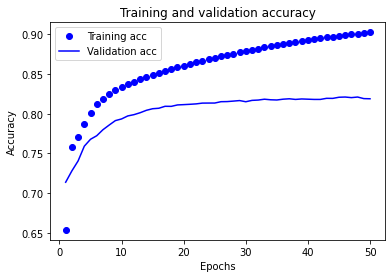

In [ ]:
plt.clf()  

acc = his_dict['acc']
val_acc = his_dict['val_acc']
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

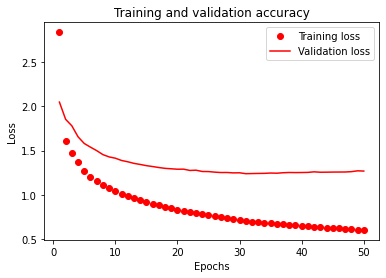

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     639296      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [ ]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)
  
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = fra_tokenizer.word_index[sos_token]

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
      # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # 예측 결과를 문자로 변환
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = fra_tokenizer.index_word[sampled_token_index]

      # 현재 시점의 예측 문자를 예측 문장에 추가
      decoded_sentence += sampled_char

      # <eos>에 도달하거나 최대 길이를 넘으면 중단.
      if (sampled_char == eos_token or
          len(decoded_sentence) > max_fra_seq_len):
          stop_condition = True

      # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
      target_seq = np.zeros((1, 1))
      target_seq[0, 0] =  sampled_token_index

      # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
      states_value = [h, c]

  return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_eng(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_fra(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx['<sos>'] and encoded_word != fra2idx['<eos>']):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

#Step 6. 모델 평가하기
단어 단위 번역기에 대해서 훈련 데이터의 샘플과 테스트 데이터의 샘플에 대해서 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요.

In [ ]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-5]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: Hi.
정답 문장: Salut 
번역기가 번역한 문장: salut.
1/1 [==============================] - 0s 19ms/step
-----------------------------------
입력 문장: Hello!
정답 문장: Salut 
번역기가 번역한 문장: salut!
1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: Hop in.
정답 문장: Montez
번역기가 번역한 문장: ensuis!
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Help me!
정답 문장: Aide-moi 
번역기가 번역한 문장: aide-moi.
1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: Humor Tom.
정답 문장: Mettez Tom de bonne humeur
번역기가 번역한 문장: regardeztomde


#결론
이번 프로젝트에서는 글자단위의 프로젝트가 아닌 단어단위의 번역기를 만들어보는 프로젝트를 진행해보았습니다.
전반적인 전처리로는 구두점을 제거하는 것이 아닌 구두점과 단어를 분리해주는 작업을 수행하였고, 소문자처리, 띄어쓰기 단위로 토큰화를 진행하는 등 디코더 문장의 시작과 끝에 토큰을 각각 넣어주었고 텍스트를 정수로 변환 해보고 임베딩층을 인코더 및 디코더 각각 다 만들어주어 단어들을 벡터화 하였습니다.
모델을 구현해보고 그래프로 분석하는 등 번역기를 실제로 돌려 결과를 평가해보는 것 까지 진행해보았습니다.

# 회고

---



## - 이번 프로젝트에서 어려웠던 점
이번에는 LMS내용 뿐만아니라 임베딩레이어를 만들어보고 인코더 디코더를 설계해보았는데 그 과정이 어려웠고 초반에 전처리부분 또한 쉽지 않았습니다. 그리고 오류해결이 오래 걸린 부분이 있었는데 마지막에 번역기 모델을 실행할 때 in user code라는 오류가 발생하면서 결과가 안나오는 부분이 있었는데 그것에 대한 해결방법은 알게된 점에서 다시 짚어야 할 것 같습니다.


---


## - 프로젝트를 진행하면서 알게된 점
이번 프로젝트에서 문제를 맞닥뜨리면서 가장 어려웠던 부분이 위에 말했듯이 in user code라는 오류였는데 loss="sparse_categorical_crossentropy" 로스 값을 지정할 때 그냥 categorical_crossentropy로 설정하였었는데 이것을 sparse로 변경해주지 않아 오류가 났었는데
sparse는 입력 값을 정수형태로 받고 그냥 categorical은 원-핫 벡터 형식으로 입력을 받는 로스함수라 오류가 났던것 같습니다.

그리고 제가 전처리한 방법으로는 토큰을 먼저 추가해주고 전처리를 해야 제대로 토큰화가 진행된다는 점을 알게 되었습니다.

---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들
데이터 전처리를 할때 최대한 깔끔하게 단어단위로 인식하게 하기 위해 "같은 구두점을 없애보았습니다


---


## - 자기다짐
NLP프로젝트를 진행할 때 이해가 좀 떨어지는 것 같아 추가적인 공부가 필요하다고 느껴 전처리 관련이나 토큰화부분을 조금 더 들여다 봐야 할 것 같습니다.

임베딩레이어 부분을 설계할 때 어려움을 겪어 코드를 더 분석해보아야 할 것 같습니다.


